In [ ]:
!git clone 'personal token...'

Cloning into 'CS464_Project'...
remote: Enumerating objects: 37932, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 37932 (delta 50), reused 16 (delta 3), pack-reused 37820 (from 1)
Receiving objects: 100% (37932/37932), 1.29 GiB | 23.41 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (37917/37917), done.


In [ ]:
%cd /content/CS464_Project/notebooks

/content/CS464_Project/notebooks


In [ ]:
!git pull

Already up to date.


In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
sys.path.append("../src")
from dataset import ISICDataset, load_data_splits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


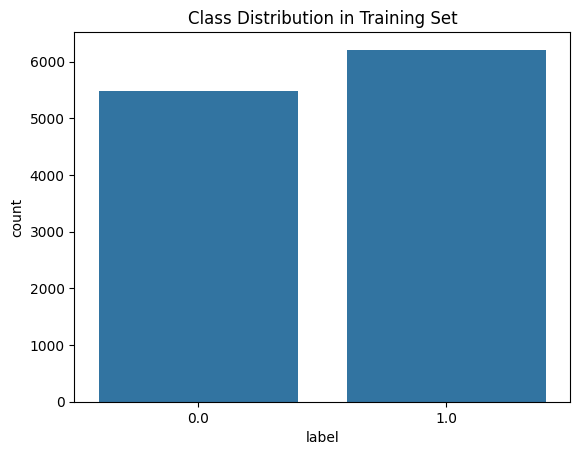

In [ ]:
img_size = 224
batch_size = 32
num_epochs = 10

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

metadata_path = "../data/raw/bcn20000_metadata_2025-03-28.csv"
train_split_path = "/content/CS464_Project/train_split.csv"
val_split_path = "/content/CS464_Project/val_split.csv"
test_split_path = "/content/CS464_Project/test_split.csv"
data_dir = "/content/CS464_Project/data/cleaned"

train_df = pd.read_csv(train_split_path)
val_df = pd.read_csv(val_split_path)
test_df = pd.read_csv(test_split_path)

train_ds = ISICDataset(train_df, data_dir, transform=transform)
val_ds = ISICDataset(val_df, data_dir, transform=transform)
test_ds = ISICDataset(test_df, data_dir, transform=transform)

# Plot class distribution
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.show()

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label'].values),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Dataloaders (test set is NOT used here)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
# Load pre-trained DenseNet169 and freeze layers
model = models.densenet169(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze layers (transfer learning)

# Replace the classifier (last layer) for binary classification
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)  # Output 1 neuron (binary)
model = nn.Sequential(model, nn.Sigmoid())  # Sigmoid for probability

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 94.5MB/s]


In [ ]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

Epoch 1, Train Loss: 0.5776, Train Accuracy: 69.67%, Val Accuracy: 68.50%
New best model saved in memory.
Epoch 2, Train Loss: 0.5381, Train Accuracy: 73.47%, Val Accuracy: 73.49%
New best model saved in memory.
Epoch 3, Train Loss: 0.5264, Train Accuracy: 73.98%, Val Accuracy: 74.69%
New best model saved in memory.
Epoch 4, Train Loss: 0.5181, Train Accuracy: 74.64%, Val Accuracy: 74.13%
Epoch 5, Train Loss: 0.5171, Train Accuracy: 74.72%, Val Accuracy: 74.25%
Epoch 6, Train Loss: 0.5116, Train Accuracy: 75.11%, Val Accuracy: 73.65%
Epoch 7, Train Loss: 0.5140, Train Accuracy: 74.67%, Val Accuracy: 74.77%
New best model saved in memory.
Epoch 8, Train Loss: 0.5100, Train Accuracy: 75.11%, Val Accuracy: 73.77%
Epoch 9, Train Loss: 0.5070, Train Accuracy: 75.57%, Val Accuracy: 73.33%
Epoch 10, Train Loss: 0.5092, Train Accuracy: 75.35%, Val Accuracy: 74.09%


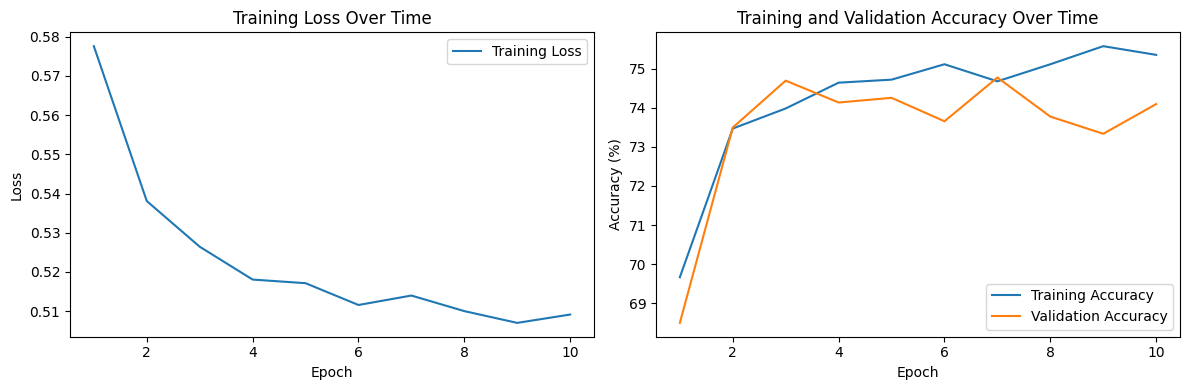

Test Accuracy: 74.26%


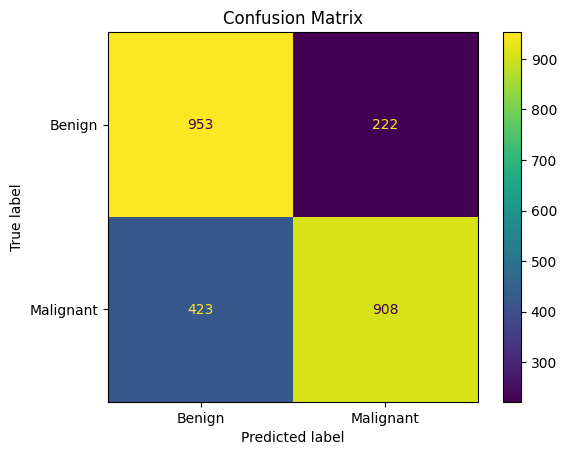


Classification Report:
              precision    recall  f1-score   support

      Benign       0.69      0.81      0.75      1175
   Malignant       0.80      0.68      0.74      1331

    accuracy                           0.74      2506
   macro avg       0.75      0.75      0.74      2506
weighted avg       0.75      0.74      0.74      2506



In [ ]:
# Modified training loop to track training loss and accuracy
train_losses = []
train_accuracies = []
val_accuracies = []

best_model = None
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    # Update best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model.state_dict().copy()
        print("New best model saved in memory.")

# Plot training loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model and evaluate on test set
model.load_state_dict(best_model)
model.eval()

# Test evaluation with confusion matrix
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant'])
print("\nClassification Report:")
print(report)

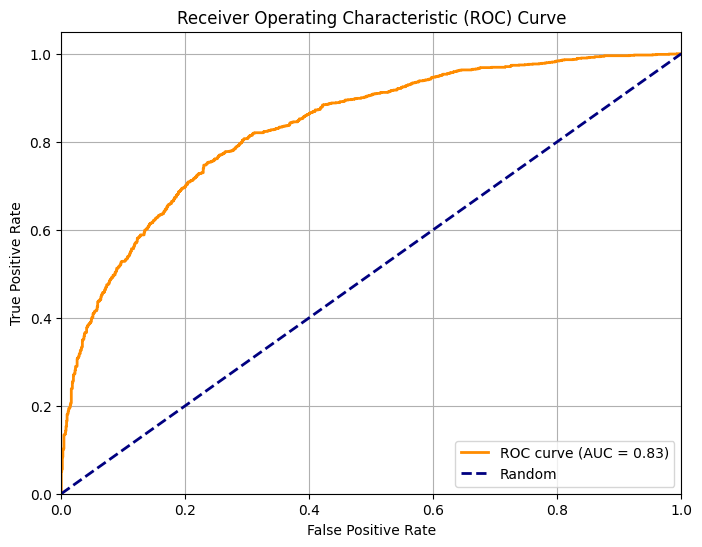

In [20]:
# Get predictions and probabilities for ROC curve
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # Shape: [batch_size, 1]
        probs = torch.sigmoid(outputs).squeeze()  # Convert logits to probabilities
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])  # Corrected line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()